# Frequency Analysis

Run all cells in sequence. We first include the global analysis method from `Methods.py`, then 
generate $k$ (complex) sinusoids with random frequencies up to Nyquist, and then recover the frequencies
in two different ways:
1. We sum the sinusoids, form the delay-embedding, learn the $k$ complex-dimensional subspace of best fit
and compute the eigenvalues of the time-shift operator on that subspace. 
2. We orthogonalize the sinsuoid directly and compute the eigenvalues of time-shift.

In [30]:
from Methods import *
# from Includes import *
matplotlib.rcParams['figure.dpi'] = 150
%matplotlib inline

Original vectors & correlation
Orthogonal defect: 0.9694452149663798


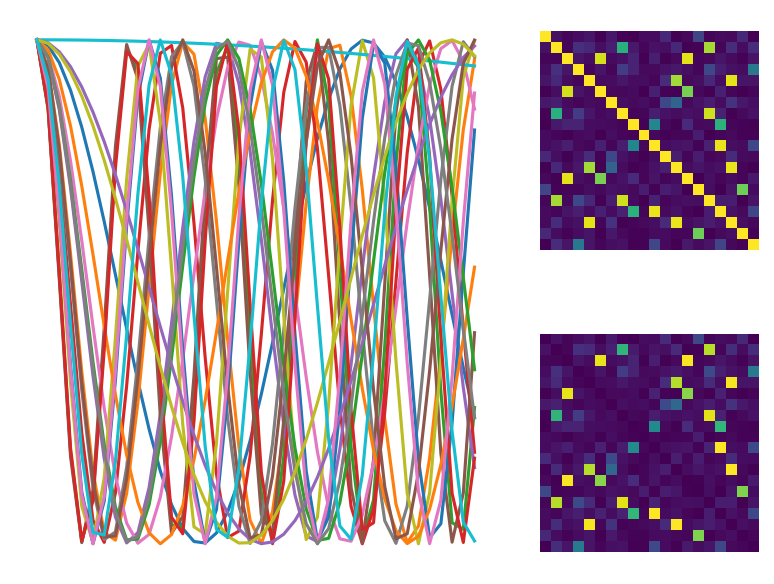

In [31]:
k = 20 # number of frequencies
SR = 48000 # sample rate
bandlimit = 8 # restrict frequencies to [0, SR / bandlimit]

fs = np.random.rand(k) * SR / bandlimit # generate random freqs

# N = bandlimit * k # set embedding dimension
N = bandlimit * k
# M = bandlimit * N # set dimension for extra rollover
M = 2 * N

phasor = 2 * np.pi * np.arange(0, M / SR, 1 / SR)
phases = np.array([phasor * f for f in fs])
source = np.exp(1j * phases)
vectors = source[:,:N]
vectors = (vectors.T / np.linalg.norm(vectors.T, axis=0)).T

print("Original vectors & correlation")
print("Orthogonal defect:", np.max(np.abs(np.conj(vectors) @ vectors.T - np.eye(k))))

fig = plt.figure()
ax1 = plt.subplot2grid((2, 3), (0, 0), rowspan = 2, colspan = 2)
ax2 = plt.subplot2grid((2, 3), (0, 2), colspan=1)
ax3 = plt.subplot2grid((2, 3), (1, 2), colspan=1)

ax1.plot(np.real(vectors.T[:2 * k]))
ax2.imshow(np.abs(np.conj(vectors) @ vectors.T))
ax3.imshow(np.abs(np.conj(vectors) @ vectors.T - np.eye(k)))

ax1.set_axis_off()
ax2.set_axis_off()
ax3.set_axis_off()

plt.show()

In [32]:
# synthetic estimate
B = vectors.T.copy()

Orthogonalized synthetic vectors
Orthogonal defect: 1.1102234728755245e-15


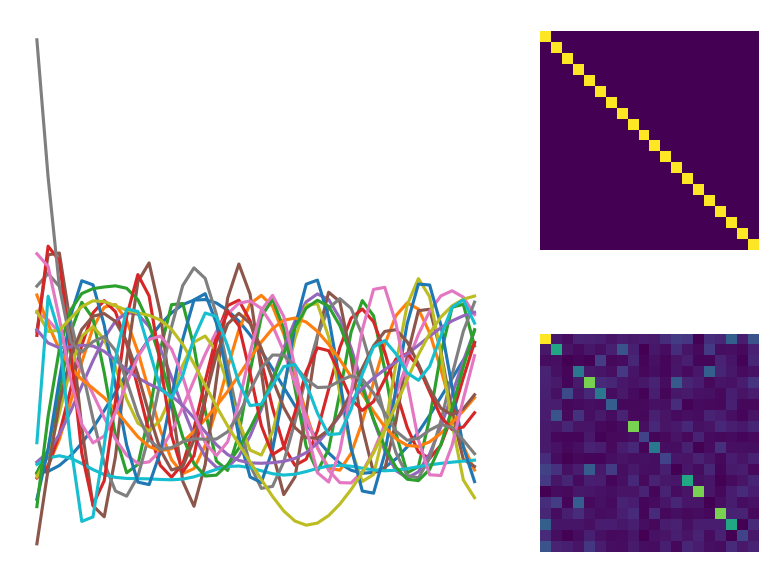

In [33]:
B = scipy.linalg.qr(B, mode = 'economic')[0]


fig = plt.figure()
ax1 = plt.subplot2grid((2, 3), (0, 0), rowspan = 2, colspan = 2)
ax2 = plt.subplot2grid((2, 3), (0, 2), colspan=1)
ax3 = plt.subplot2grid((2, 3), (1, 2), colspan=1)

ax1.plot(np.real(B[:2 * k]))
ax2.imshow(np.abs(np.conj(B.T) @ B))
ax3.imshow(np.abs(np.conj(B.T) @ B - np.eye(k)))

ax1.set_axis_off()
ax2.set_axis_off()
ax3.set_axis_off()

print("Orthogonalized synthetic vectors")
print("Orthogonal defect:", np.max(np.abs(np.conj(B.T) @ B - np.eye(k))))

plt.show()

In [34]:
# "observed", i.e. delay-embedded
coeffs = np.ones(k)
signal = source.T @ coeffs

trajectory, bases, distances, sep = analyze(signal, list(range(N)), k, alpha = 0.995, delta = 1, dtype = 'complex', randomize = True, mode = 'qr', corrected = True, normalize = True, pad = False)
A = np.conj(bases[-1])

100%|█████████████████████████████████████████████████████████████████████████████████| 162/162 [00:22<00:00,  7.07it/s]


In [35]:
length = 3
longphasor = 2 * np.pi * np.arange(0, length, 1 / SR)
multichannel = np.exp(1j * np.array([longphasor * f for f in fs]))
audio = np.real(np.sum(multichannel, axis = 0) / k)
ipd.Audio(audio, rate = SR)

Orthogonalized vectors learned from delay embedding
Projection defect: 8.440290794073613e-35
Orthogonal defect: 8.881784772319157e-16


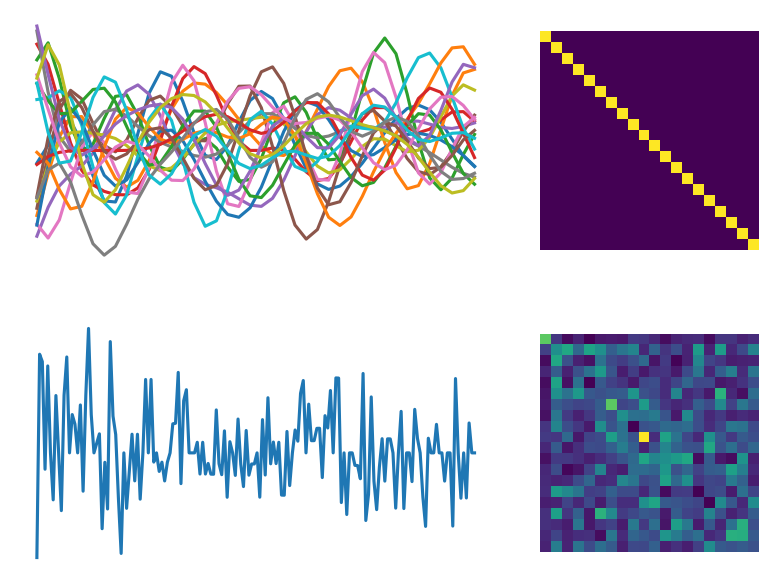

In [36]:
fig = plt.figure()
ax1 = plt.subplot2grid((2, 3), (0, 0), rowspan = 1, colspan = 2)
ax2 = plt.subplot2grid((2, 3), (0, 2), colspan=1)
ax3 = plt.subplot2grid((2, 3), (1, 2), colspan=1)
ax4 = plt.subplot2grid((2, 3), (1, 0), colspan=2)

ax1.plot(np.real(A[:2 * k]))
ax2.imshow(np.abs(np.conj(A.T) @ A))
ax3.imshow(np.abs(np.conj(A.T) @ A - np.eye(k)))
ax4.plot(distances)

ax1.set_axis_off()
ax2.set_axis_off()
ax3.set_axis_off()
ax4.set_axis_off()

print("Orthogonalized vectors learned from delay embedding")
print("Projection defect:", distances[-1])
print("Orthogonal defect:", np.max(np.abs(np.conj(A.T) @ A - np.eye(k))))

plt.show()

In [37]:
print("Estimate from delay embedding and subspace learning:\n")

Z = A
S = np.linalg.inv(np.conj(Z[:-1,:].T) @ Z[:-1,:]) @ np.conj(Z[:-1,:].T) @ Z[1:,:]

omegas = np.linalg.eigvals(S)

freqs = np.sort([np.angle(o) * SR / (2 * np.pi) for o in omegas])[::-1]
fs = np.sort(fs)[::-1]

print("Detected:", freqs, "\n")

print("True:", fs, "\n")

# compute errors by comparing each estimated frequency from freqs
# to nearest element of the true frequencies, fs
errs = np.zeros(k)

for i,f in enumerate(freqs):
    a = np.argmin(np.abs(f - fs))
    errs[i] = f - fs[a]

print("Errors", errs, "\n")

magnitude = np.log(np.abs(errs[errs != 0]))
mean = np.mean(magnitude[magnitude != -np.inf]) if len(magnitude) else 0

# typical accuracy is has the average order of magnitude of error in frequency
print("Typical accuracy:", np.exp(mean),"Hz.\n", "Worst case:", np.max(np.abs(errs)),"Hz.\n", "Best case:", np.min(np.abs(errs)),"Hz.\n")

Estimate from delay embedding and subspace learning:

Detected: [5814.2138447  5752.70913355 5704.92472187 4941.72539756 4793.38683691
 4751.9582257  4337.16790224 4135.24642604 3764.66823749 3701.92542219
 3614.33358041 2920.38185018 2871.90081947 2830.82496736 2610.30486413
 2173.02011358 1640.36641881 1300.76044037 1187.24367135   90.07422026] 

True: [5814.21384223 5752.70912602 5704.92472318 4941.72539646 4793.38687503
 4751.95828602 4337.16790035 4135.24643172 3764.66824483 3701.92485773
 3614.33357715 2920.38252539 2871.90169568 2830.82415709 2610.30486687
 2173.02011354 1640.36641881 1300.76044039 1187.24367135   90.07422026] 

Errors [ 2.47363732e-06  7.53090990e-06 -1.31393153e-06  1.09985922e-06
 -3.81147247e-05 -6.03235367e-05  1.89605998e-06 -5.68358428e-06
 -7.34846526e-06  5.64461856e-04  3.25321116e-06 -6.75201507e-04
 -8.76209201e-04  8.10273365e-04 -2.73648675e-06  4.21591722e-08
 -2.63071342e-09 -2.04418029e-08  2.76713763e-09 -1.23789334e-09] 

Typical accuracy: 2.5

In [38]:
print("Synthetic estimate (from orthogonalizing sinusoids directly)\n")

Y = np.random.random((k,k)) + 1j * np.random.random((k, k))
Y = Y - np.conj(Y.T)
X = scipy.linalg.expm(Y)

# mix up by a random orthogonal matrix
Z = B @ X
S = np.linalg.inv(np.conj(Z[:-1,:].T) @ Z[:-1,:]) @ np.conj(Z[:-1,:].T) @ Z[1:,:]

omegas = np.linalg.eigvals(S)

freqs = np.sort([np.angle(o) * SR / (2 * np.pi) for o in omegas])
fs = np.sort(fs)

print("Detected:", freqs, "\n")

print("True:", fs, "\n")

# compute errors by comparing each estimated frequency from freqs
# to nearest element of the true frequencies, fs
errs = np.zeros(k)

for i,f in enumerate(freqs):
    a = np.argmin(np.abs(f - fs))
    errs[i] = f - fs[a]

print("Errors", errs, "\n")

magnitude = np.log(np.abs(errs[errs != 0]))
mean = np.mean(magnitude[magnitude != -np.inf]) if len(magnitude) else -np.inf

# typical accuracy is has the average order of magnitude of error in frequency
print("Typical accuracy:", np.exp(mean),"Hz.\n", "Worst case:", np.max(np.abs(errs)),"Hz.\n", "Best case:", np.min(np.abs(errs)),"Hz.\n")

Synthetic estimate (from orthogonalizing sinusoids directly)

Detected: [  90.07422026 1187.24367135 1300.76044039 1640.36641881 2173.02011354
 2610.30486687 2830.82415709 2871.90169568 2920.38252539 3614.33357715
 3701.92485773 3764.66824483 4135.24643172 4337.16790035 4751.95828602
 4793.38687503 4941.72539646 5704.92472318 5752.70912602 5814.21384223] 

True: [  90.07422026 1187.24367135 1300.76044039 1640.36641881 2173.02011354
 2610.30486687 2830.82415709 2871.90169568 2920.38252539 3614.33357715
 3701.92485773 3764.66824483 4135.24643172 4337.16790035 4751.95828602
 4793.38687503 4941.72539646 5704.92472318 5752.70912602 5814.21384223] 

Errors [-8.73967565e-12  7.50333129e-12  3.41060513e-12 -8.64019967e-12
 -2.72848411e-12 -1.68256520e-11 -4.23369784e-10  8.13997758e-10
 -3.82897269e-10  4.45652404e-11  1.20053301e-10 -1.73713488e-10
 -8.18545232e-12  9.09494702e-13  2.18278728e-11 -3.91082722e-11
 -1.63709046e-11  1.36424205e-11 -8.73114914e-11  1.45519152e-11] 

Typical accur